# Analyzing Audits

**Predicting Cell Health**

**Gregory Way, 2019**

Detecting replicate correlation across replicates and CRISPR guides targetting the same gene.

Audits were generated using `generate_audits.sh`, which calls [`broadinstitute/cytominer_scripts/audit.R`](https://github.com/broadinstitute/cytominer_scripts/blob/master/audit.R).

In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt
import plotnine as gg

from scripts.audit_utils import get_confidence

In [2]:
%matplotlib inline
%load_ext rpy2.ipython

In [3]:
# Load Audits
# (both detailed treatments and null threshold summaries)
data_dir = os.path.join("..", "..", "..", "scratch", "CRISPR_PILOT_B1", "audit")

audit_df_list = []
audit_summary_list = []
audit_guide_df_list = []

# Load all audit data and allocate to proper data frame
for file in os.listdir(data_dir):
    full_file = os.path.join(data_dir, file)
    df = pd.read_csv(full_file)

    if 'detailed.csv' in file:
        audit_df_list.append(df)
    if 'audit.csv' in file:
        audit_summary_list.append(df)
    if 'detailed_guide.csv' in file:
        audit_guide_df_list.append(df)

# Concatenate all detailed audits
audit_df = (
    pd.concat(audit_df_list)
    .sort_values(by=['Metadata_gene_name',
                     'Metadata_pert_name',
                     'Metadata_cell_line'])
    .reset_index(drop=True)
)

# Concatenate the summary audits
summary_audit_df = (
    pd.concat(audit_summary_list)
    .reset_index(drop=True)
)

# Concatenate replicate guide audit
audit_guide_df = (
    pd.concat(audit_guide_df_list)
    .sort_values(by=['Metadata_cell_line',
                     'Metadata_gene_name'])
    .reset_index(drop=True)
)

In [4]:
# How many genes have CRISPR guides?
print(len(audit_df.Metadata_gene_name.unique()))

# How many guides per gene and per cell line
pd.crosstab(audit_df.Metadata_cell_line,
            audit_df.Metadata_gene_name).T.head(5)

58


Metadata_cell_line,A549,ES2,HCC44
Metadata_gene_name,,,
AKT1,4,4,4
ARID1B,4,4,4
ATF4,4,4,4
ATP50,4,4,4
AURKB,2,2,2


## Interpretation of `correlation`

The audit process (generated using [broadinstitute/cytominer_scripts/audit.R](https://github.com/broadinstitute/cytominer_scripts/blob/master/audit.R)) identifies median pairwise correlations between all replicates within plate maps, genes, and guides.

Therefore, the `correlation` column represents the pairwise correlation across replicates **within batch**.

In [5]:
print(audit_df.shape)
audit_df.head(4)

(984, 12)


,Metadata_Plate_Map_Name,Metadata_Well,Metadata_gene_name,Metadata_pert_name,Metadata_broad_sample,Metadata_cell_line,Metadata_pert_id,Metadata_pert_mfc_id,Metadata_cell_id,Metadata_broad_sample_type,Metadata_pert_type,correlation
0,DEPENDENCIES1_A549,A03,AKT1,AKT1-1,BRDN0001054908,A549,NaN,BRDN0001054908,unknown,trt,trt,-0.011884
1,DEPENDENCIES1_A549,O22,AKT1,AKT1-1,BRDN0001054908,A549,NaN,BRDN0001054908,unknown,trt,trt,0.467280
2,DEPENDENCIES1_ES2,A03,AKT1,AKT1-1,BRDN0001054908,ES2,NaN,BRDN0001054908,unknown,trt,trt,0.393790
3,DEPENDENCIES1_ES2,O22,AKT1,AKT1-1,BRDN0001054908,ES2,NaN,BRDN0001054908,unknown,trt,trt,0.361178


## Interpretation of `null_threshold`

The `null_threshold` column above is also generated in [broadinstitute/cytominer_scripts/audit.R](https://github.com/broadinstitute/cytominer_scripts/blob/master/audit.R).

The metric represents a random sampling of different samples and combined, over many iterations, to represent the 95% quantile of the null distribution of pairwise correlation.

In [6]:
# Process the summary audits
summary_audit_df = (
    pd.concat(
        [summary_audit_df,
         summary_audit_df.plate_map_name.str.split('_', expand=True).iloc[:, 1]],
        axis='columns'
    )
    .rename(columns={1: 'Metadata_cell_line'})
)

summary_audit_df

,plate_map_name,null_threshold,fraction_strong,null_quantile,Metadata_cell_line
0,DEPENDENCIES1_HCC44,0.478146,0.545732,0.95,HCC44
1,DEPENDENCIES1_ES2,0.435187,0.506098,0.95,ES2
2,DEPENDENCIES1_A549,0.700114,0.341463,0.95,A549


## Generate Median Correlation of Replicates _Across_ Batch

We are interested in identifying the median correlation of all replicates (guides, cell lines, targets) across batches.

### Interpretation of `median_replicate_correlation`

This value represents the median correlation across all **replicates** targetting the given gene for the given cell line **across** batches.

Therefore, the `median_replicate_correlation` is a median (guides across batches) of medians (replicates of single guides within batch) of medians (profiles of individual cells in a single well).

In [7]:
audit_group_cols = ['Metadata_gene_name', 'Metadata_pert_name', 'Metadata_cell_line']
audit_correlation_cols = audit_group_cols + ['correlation_ci_low', 'correlation_ci_high']

median_replicate_correlation_df = (
    audit_df
    .groupby(audit_group_cols)
    .apply(get_confidence)
    .reset_index(drop=True)
    .assign(num_replicates=0)
    .groupby(audit_correlation_cols)
    .agg(
        {'correlation': 'median',
         'num_replicates': 'size'}
    )
    .reset_index()
    .rename(
        columns=
        {'correlation': 'median_replicate_correlation',
         'correlation_ci_low': 'replicate_cor_ci_low',
         'correlation_ci_high': 'replicate_cor_ci_high'}
    )
)

print(median_replicate_correlation_df.shape)
median_replicate_correlation_df.head(2)

(354, 7)


,Metadata_gene_name,Metadata_pert_name,Metadata_cell_line,replicate_cor_ci_low,replicate_cor_ci_high,median_replicate_correlation,num_replicates
0,AKT1,AKT1-1,A549,-0.299618,0.755014,0.227698,2
1,AKT1,AKT1-1,ES2,0.341594,0.413374,0.377484,2


## Generate Median Correlation of *Guides Targetting the Same Gene*

We are also interested in identifying the median correlation of all guides that target a single gene.

## Interpretation of `median_target_correlation`

This value represents the median correlation across all **guides** targetting the same gene for the given cell line.

The median target correlation is calculated within batch for all profiles generated by guides targetting the same gene within each cell line.

In [8]:
# Summarize the audits using median correlation for all guides across genes, and cell lines
audit_guide_cols = ['Metadata_gene_name', 'Metadata_cell_line']
audit_guide_correlation_cols = audit_guide_cols + ['correlation_ci_low', 'correlation_ci_high']

median_target_correlation_df = (
    median_replicate_correlation_df
    .groupby(audit_guide_cols)
    .apply(lambda x: get_confidence(x, col='median_replicate_correlation'))
    .reset_index(drop=True)
    .groupby(audit_guide_correlation_cols)
    .agg(
        {'median_replicate_correlation': 'median',
         'num_replicates': 'sum'}
    )
    .reset_index()
    .rename(
        columns=
            {'median_replicate_correlation': 'median_target_correlation',
             'num_replicates': 'num_guides',
             'correlation_ci_low': 'target_cor_ci_low',
             'correlation_ci_high': 'target_cor_ci_high'}
    )
)

print(median_target_correlation_df.shape)
median_target_correlation_df.head()

/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(159, 6)


,Metadata_gene_name,Metadata_cell_line,target_cor_ci_low,target_cor_ci_high,median_target_correlation,num_guides
0,AKT1,A549,-0.010049,0.794073,0.392012,4
1,AKT1,ES2,-0.184580,0.613422,0.214421,4
2,AKT1,HCC44,0.127259,0.916646,0.521952,4
3,ARID1B,A549,0.457704,0.692591,0.575147,4
4,ARID1B,ES2,-0.424798,1.078670,0.326936,4


## Merge Audit Data Together for Plotting

In [9]:
# Merge summarized data into audit dataframe
guide_merge_cols = ['Metadata_gene_name', 'Metadata_cell_line', 'Metadata_pert_name']
gene_merge_cols = ['Metadata_gene_name', 'Metadata_cell_line']

audit_correlation_df = (
    audit_df
    .merge(
        median_replicate_correlation_df,
        left_on=guide_merge_cols,
        right_on=guide_merge_cols,
        how='outer'
    )
    .merge(
        median_target_correlation_df,
        left_on=gene_merge_cols,
        right_on=gene_merge_cols,
        how='outer'
    )
)

# Determine how many CRISPRs are targetting the gene
audit_correlation_df = (
    audit_correlation_df
    .assign(
        guide_index=(
            audit_df
            .groupby(guide_merge_cols)
            .cumcount()+1
        )
        .tolist()
    )
    .sort_values(by='median_target_correlation',
                 ascending=False)
    .reset_index(drop=True)
)

audit_correlation_df.guide_index = audit_correlation_df.guide_index.astype('str')
audit_correlation_df.head()

,Metadata_Plate_Map_Name,Metadata_Well,Metadata_gene_name,Metadata_pert_name,Metadata_broad_sample,Metadata_cell_line,Metadata_pert_id,Metadata_pert_mfc_id,Metadata_cell_id,Metadata_broad_sample_type,...,correlation,replicate_cor_ci_low,replicate_cor_ci_high,median_replicate_correlation,num_replicates,target_cor_ci_low,target_cor_ci_high,median_target_correlation,num_guides,guide_index
0,DEPENDENCIES1_HCC44,M06,ITGAV,ITGAV-1,BRDN0001052092,HCC44,NaN,BRDN0001052092,unknown,trt,...,0.941955,0.931211,0.945986,0.938598,2,0.912882,0.949393,0.931138,4.0,2
1,DEPENDENCIES1_HCC44,C19,ITGAV,ITGAV-1,BRDN0001052092,HCC44,NaN,BRDN0001052092,unknown,trt,...,0.935242,0.931211,0.945986,0.938598,2,0.912882,0.949393,0.931138,4.0,1
2,DEPENDENCIES1_HCC44,C21,ITGAV,ITGAV-2,BRDN0001052667,HCC44,NaN,BRDN0001052667,unknown,trt,...,0.901707,0.875322,0.972032,0.923677,2,0.912882,0.949393,0.931138,4.0,1
3,DEPENDENCIES1_HCC44,M04,ITGAV,ITGAV-2,BRDN0001052667,HCC44,NaN,BRDN0001052667,unknown,trt,...,0.945647,0.875322,0.972032,0.923677,2,0.912882,0.949393,0.931138,4.0,2
4,DEPENDENCIES1_HCC44,J10,POLR2D,POLR2D-2,NaN,HCC44,NaN,NaN,unknown,trt,...,0.937823,0.899674,0.933388,0.920565,8,0.914159,0.923254,0.918707,16.0,5


In [10]:
# Get audit_df ready to plot
gene_name_cat = pd.CategoricalDtype(categories=audit_correlation_df.Metadata_gene_name.unique().tolist())
audit_correlation_df = audit_correlation_df.assign(
    gene_plot_id=audit_correlation_df.Metadata_gene_name.astype(str).astype(gene_name_cat)
)

# Merge with the summary to add in cell line specific lines
audit_correlation_df = (
    audit_correlation_df
    .merge(summary_audit_df,
           left_on='Metadata_cell_line',
           right_on='Metadata_cell_line')
)

audit_correlation_df.head()

,Metadata_Plate_Map_Name,Metadata_Well,Metadata_gene_name,Metadata_pert_name,Metadata_broad_sample,Metadata_cell_line,Metadata_pert_id,Metadata_pert_mfc_id,Metadata_cell_id,Metadata_broad_sample_type,...,target_cor_ci_low,target_cor_ci_high,median_target_correlation,num_guides,guide_index,gene_plot_id,plate_map_name,null_threshold,fraction_strong,null_quantile
0,DEPENDENCIES1_HCC44,M06,ITGAV,ITGAV-1,BRDN0001052092,HCC44,NaN,BRDN0001052092,unknown,trt,...,0.912882,0.949393,0.931138,4.0,2,ITGAV,DEPENDENCIES1_HCC44,0.478146,0.545732,0.95
1,DEPENDENCIES1_HCC44,C19,ITGAV,ITGAV-1,BRDN0001052092,HCC44,NaN,BRDN0001052092,unknown,trt,...,0.912882,0.949393,0.931138,4.0,1,ITGAV,DEPENDENCIES1_HCC44,0.478146,0.545732,0.95
2,DEPENDENCIES1_HCC44,C21,ITGAV,ITGAV-2,BRDN0001052667,HCC44,NaN,BRDN0001052667,unknown,trt,...,0.912882,0.949393,0.931138,4.0,1,ITGAV,DEPENDENCIES1_HCC44,0.478146,0.545732,0.95
3,DEPENDENCIES1_HCC44,M04,ITGAV,ITGAV-2,BRDN0001052667,HCC44,NaN,BRDN0001052667,unknown,trt,...,0.912882,0.949393,0.931138,4.0,2,ITGAV,DEPENDENCIES1_HCC44,0.478146,0.545732,0.95
4,DEPENDENCIES1_HCC44,J10,POLR2D,POLR2D-2,NaN,HCC44,NaN,NaN,unknown,trt,...,0.914159,0.923254,0.918707,16.0,5,POLR2D,DEPENDENCIES1_HCC44,0.478146,0.545732,0.95


## Visualize Data

1. Visualize the correlation of replicates within batches for each gene and cell line.
2. Visualize the distribution of replicates of CRISPR experiments across batches.
3. Visualize the correlation of CRISPR guides targeting the same gene.

### 1. Replicate Correlation

/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/positions/position.py:192: UserWarning: position_dodge requires non-overlapping x intervals
  warn(msg.format(cls.__name__))
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/positions/position.py:192: UserWarning: position_dodge requires non-overlapping x intervals
  warn(msg.format(cls.__name__))
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/positions/position.py:192: UserWarning: position_dodge requires non-overlapping x intervals
  warn(msg.format(cls.__name__))


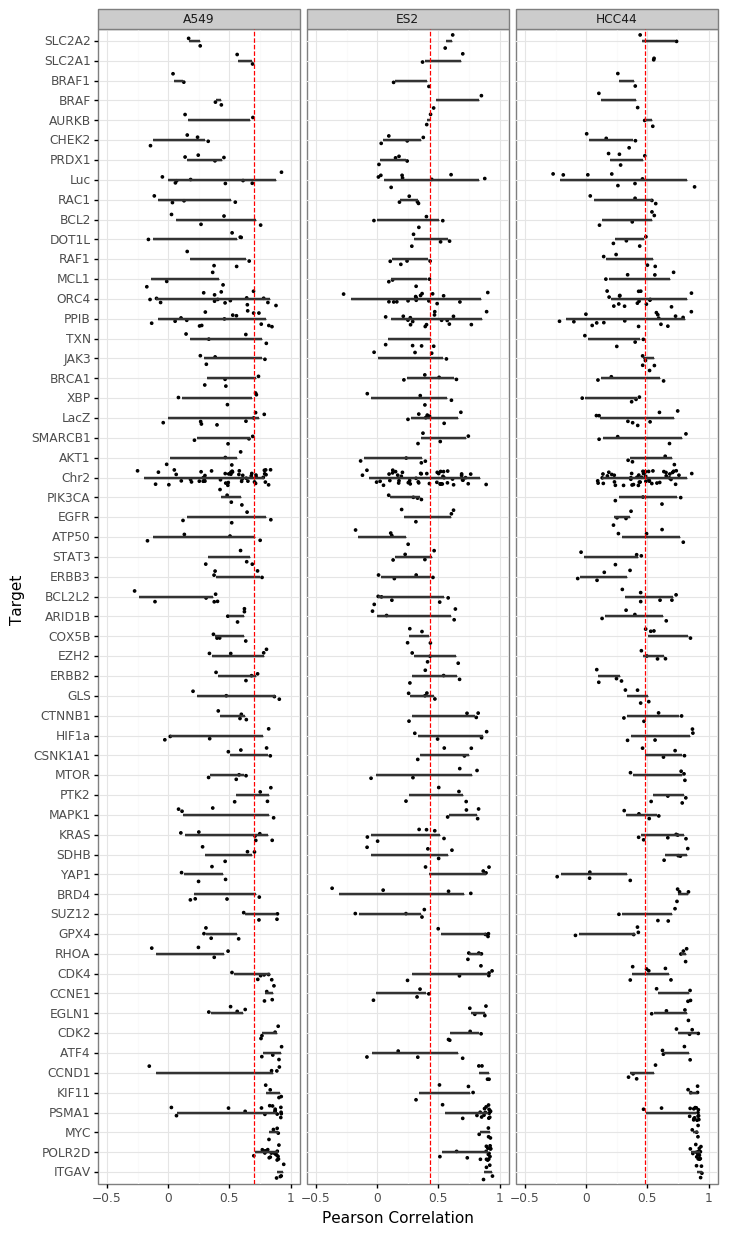

<ggplot: (-9223372036543596684)>

In [11]:
gg.options.figure_size=(8, 15)

replicate_correlation_gg = (
    gg.ggplot(audit_correlation_df,
              gg.aes(x="correlation",
                     y="gene_plot_id")) + \
        gg.geom_jitter(size=0.5,
                       width=0,
                       height=0.4) + \
        gg.geom_boxplot() + \
        gg.xlab("Pearson Correlation") + \
        gg.ylab("Target") + \
        gg.geom_vline(gg.aes(xintercept="null_threshold"),
                      linetype='dashed',
                      color='red') + \
        gg.xlim([-0.5, 1]) + \
        gg.facet_grid("~Metadata_cell_line") + \
        gg.theme_bw()
)

replicate_correlation_gg

In [12]:
file = os.path.join("figures", "replicate-correlation")
for extension in ['.png', '.pdf']:
    gg.ggsave(replicate_correlation_gg,
              filename='{}{}'.format(file, extension),
              dpi=300,
              height=15,
              width=8,
              units='in')

/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 8 x 15 in image.
  from_inches(height, units), units))
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/replicate-correlation.png
  warn('Filename: {}'.format(filename))
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/positions/position.py:192: UserWarning: position_dodge requires non-overlapping x intervals
  warn(msg.format(cls.__name__))
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/positions/position.py:192: UserWarning: position_dodge requires non-overlapping x intervals
  warn(msg.format(cls.__n

### 2. Gene Correlation

/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/layer.py:360: UserWarning: stat_density : Removed 15 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


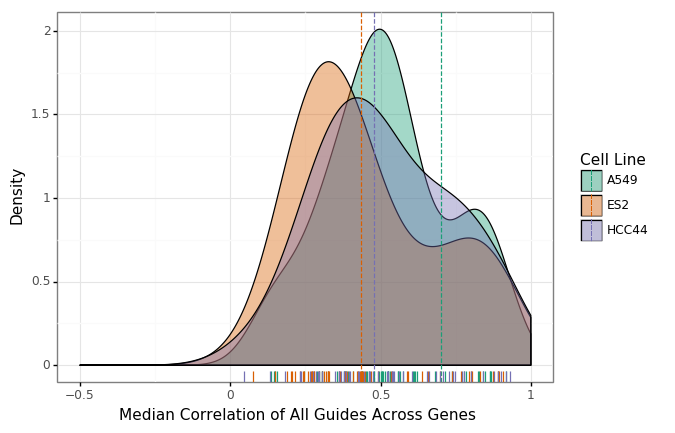

<ggplot: (314782959)>

In [13]:
gg.options.figure_size=(6.4, 4.8)

# Make sure to drop duplicates of redundant gene, perturbation, and cell line columns
# Not removing replicates will put more weight on genes with more measurements

cor_density_gg = (
    gg.ggplot(audit_correlation_df.drop_duplicates(["Metadata_cell_line",
                                                    "Metadata_gene_name"]),
              gg.aes(x="median_target_correlation")) + \
        gg.geom_density(gg.aes(fill="Metadata_cell_line"),
                        alpha=0.4) + \
        gg.geom_vline(gg.aes(xintercept="null_threshold",
                             color="Metadata_cell_line"),
                      linetype='dashed') + \
        gg.geom_rug(gg.aes(color="Metadata_cell_line"),
                    show_legend={'color': False}) + \
        gg.theme_bw() + \
        gg.xlim([-0.5, 1]) + \
        gg.xlab("Median Correlation of All Guides Across Genes") + \
        gg.ylab("Density") + \
        gg.scale_fill_manual(name="Cell Line",
                             values=["#1b9e77", "#d95f02", "#7570b3"]) + \
        gg.scale_color_manual(name="Cell Line",
                              values=["#1b9e77", "#d95f02", "#7570b3"])
)

cor_density_gg

In [14]:
file = os.path.join("figures", "median-guide-correlation-density")
for extension in ['.png', '.pdf']:
    gg.ggsave(cor_density_gg,
              filename='{}{}'.format(file, extension),
              dpi=300,
              height=4.8,
              width=6.4,
              units='in')

/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/median-guide-correlation-density.png
  warn('Filename: {}'.format(filename))
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/layer.py:360: UserWarning: stat_density : Removed 15 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: figures/median-guide-correlation-density.pdf
  warn('Filename: {}'.format(filename))
/Users/gway/miniconda3/envs/cell-health/

### 3. CRISPR Guide Correlation

In [15]:
guide_merge_cols = ['Metadata_cell_line', 'Metadata_gene_name']

audit_guide_plot_df = (
    audit_guide_df.merge(
        median_target_correlation_df,
        left_on=guide_merge_cols,
        right_on=guide_merge_cols,
        how='outer'
    )
)

# Setup plotting logic for scatter plot
audit_guide_plot_df = audit_guide_plot_df.assign(num_guides_plot=audit_guide_plot_df.num_guides / 2)
audit_guide_plot_df.loc[audit_guide_plot_df.num_guides_plot.isna(), 'num_guides_plot'] = 1
audit_guide_plot_df.num_guides_plot = audit_guide_plot_df.num_guides_plot.astype(int)
audit_guide_plot_df.loc[audit_guide_plot_df.num_guides_plot > 5, 'num_guides_plot'] = ">5"
audit_guide_plot_df.num_guides_plot = audit_guide_plot_df.num_guides_plot.astype(str)

audit_guide_plot_df.loc[audit_guide_plot_df.num_guides_plot == '1', 'median_target_correlation'] = \
 audit_guide_plot_df.loc[audit_guide_plot_df.num_guides_plot == '1', 'correlation']

file = os.path.join("data", "audit_guide_replicate_correlation.tsv")
audit_guide_df.to_csv(file, sep='\t', index=False)

audit_guide_plot_df.head()

,Metadata_cell_line,Metadata_Plate_Map_Name,Metadata_gene_name,Metadata_pert_type,correlation,target_cor_ci_low,target_cor_ci_high,median_target_correlation,num_guides,num_guides_plot
0,A549,DEPENDENCIES1_A549,AKT1,trt,0.081694,-0.010049,0.794073,0.392012,4.0,2
1,A549,DEPENDENCIES1_A549,ARID1B,trt,0.451135,0.457704,0.692591,0.575147,4.0,2
2,A549,DEPENDENCIES1_A549,ATF4,trt,0.877625,0.795140,0.930976,0.863058,4.0,2
3,A549,DEPENDENCIES1_A549,ATP50,trt,0.518263,-0.485932,1.096471,0.305269,4.0,2
4,A549,DEPENDENCIES1_A549,AURKB,trt,0.256179,NaN,NaN,0.256179,NaN,1


/Users/gway/miniconda3/envs/cell-health/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


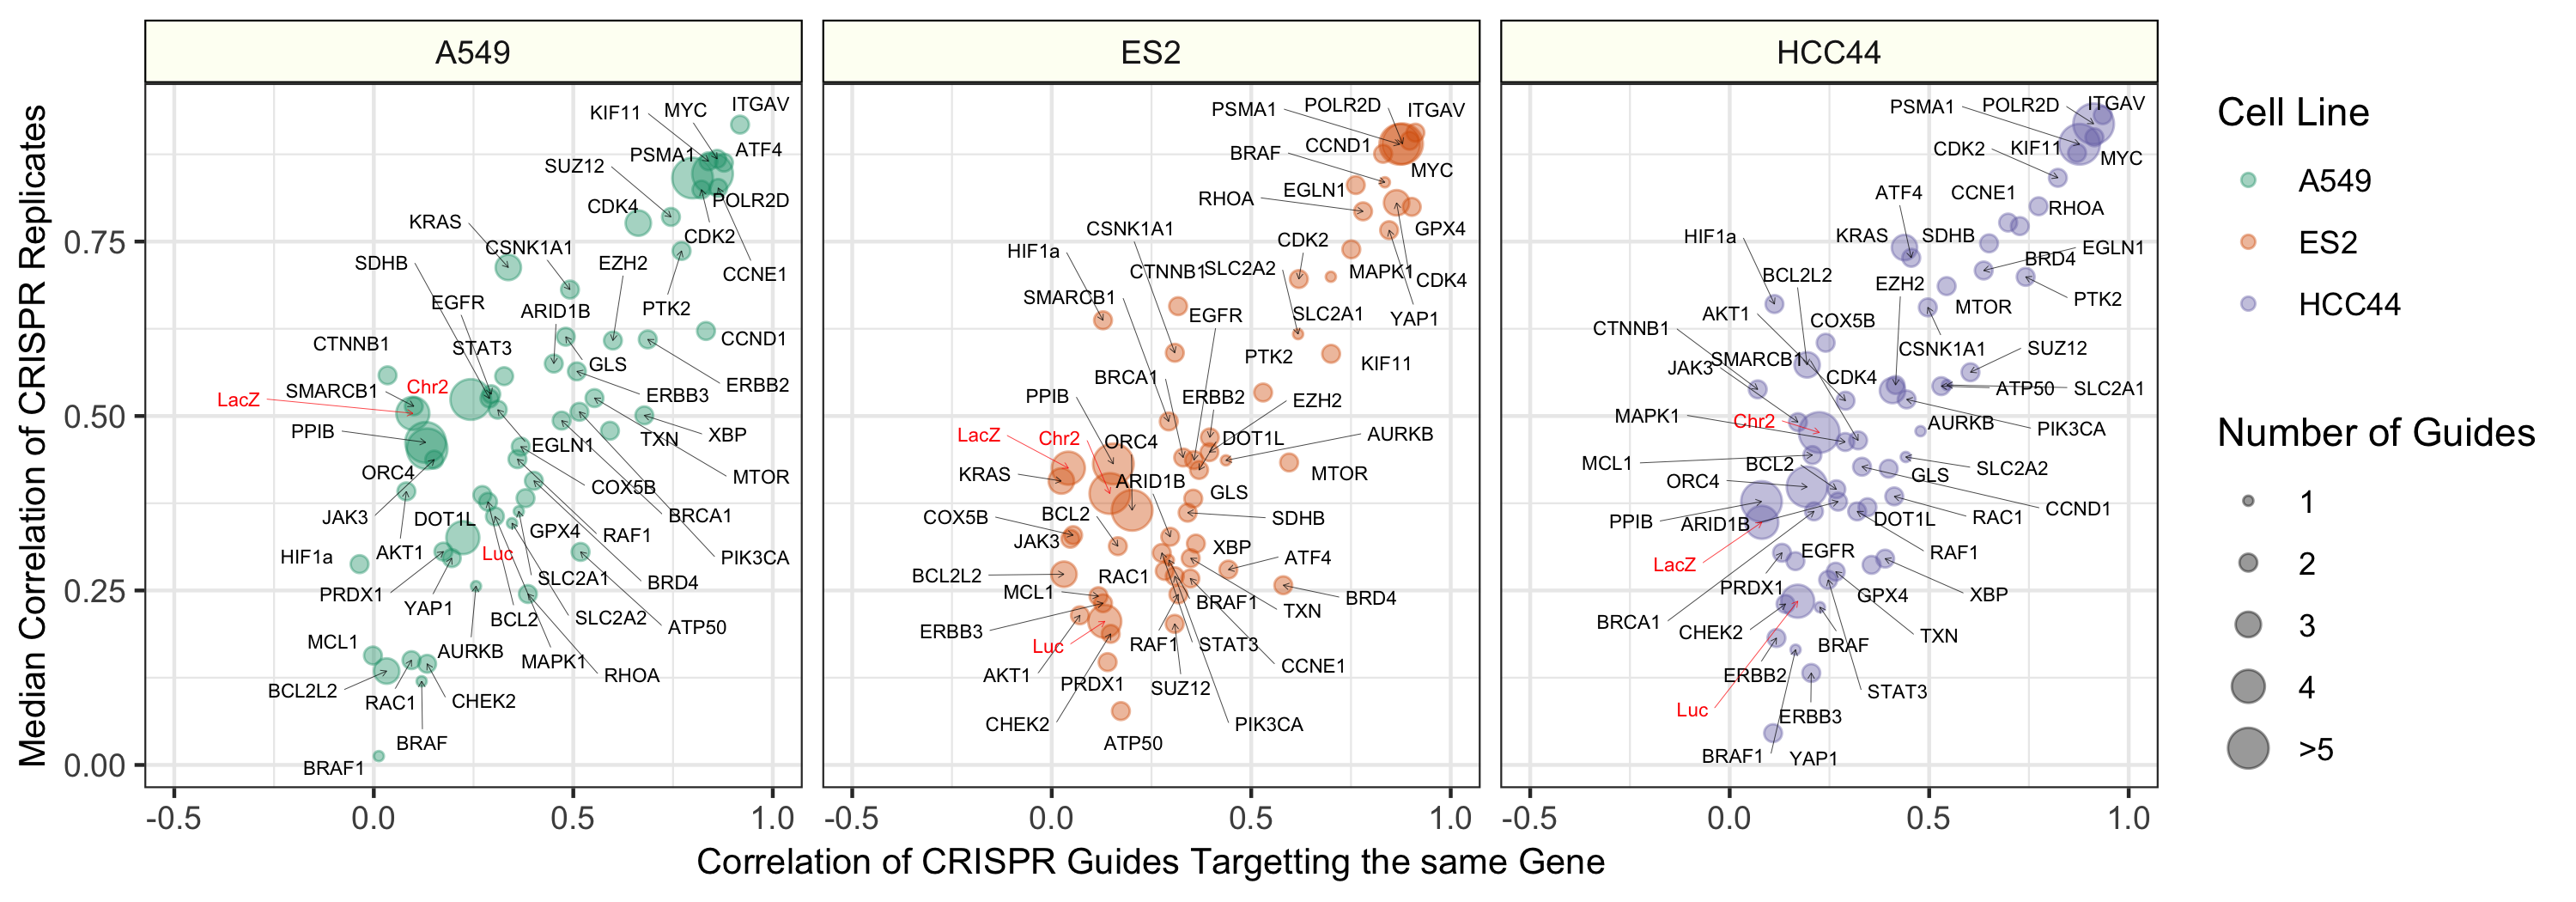

In [16]:
%%R -i audit_guide_plot_df -h 3.5 -w 10 --units in -r 300

suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrepel))

axis_title_size <- 10
axis_text_size <- 9
strip_text_size <- 9
ggrepel_label_size <- 1.9
title_text_size <- 10

text_color_logic <- audit_guide_plot_df$Metadata_gene_name %in% c("LacZ", "Luc", "Chr2")
control_text_color <- ifelse(text_color_logic, "red", "black")

audit_guide_plot_df$num_guides_plot <-
    factor(audit_guide_plot_df$num_guides_plot, levels = c("1", "2", "3", "4", ">5"))

guide_correlation_gg <-
    ggplot(audit_guide_plot_df,
           aes(x=correlation,
               y=median_target_correlation)) +
    geom_point(aes(color=Metadata_cell_line,
                   size=num_guides_plot),
               alpha=0.4) +
    geom_text_repel(arrow = arrow(length = unit(0.01, "npc")),
                    size = ggrepel_label_size,
                    segment.size = 0.1,
                    segment.alpha = 0.8,
                    force = 20,
                    color = control_text_color,
                    aes(x = correlation,
                        y = median_target_correlation,
                        label = Metadata_gene_name)) +
    xlab("Correlation of CRISPR Guides Targetting the same Gene") +
    ylab("Median Correlation of CRISPR Replicates") +
    facet_grid(~Metadata_cell_line) +
    scale_color_manual(name="Cell Line",
                       values=c("A549" = "#1b9e77",
                                "ES2" = "#d95f02",
                                "HCC44" = "#7570b3")) +
    scale_size_manual(name="Number of Guides",
                      labels=c("1" = "1",
                               "2" = "2",
                               "3" = "3",
                               "4" = "4",
                               ">5" = ">5"),
                      values=c("1" = 1,
                               "2" = 2,
                               "3" = 3,
                               "4" = 4,
                               ">5" = 5)) +
    xlim(c(-0.5, 1)) +
    theme_bw() +
    theme(axis.text = element_text(size = axis_text_size),
          axis.title = element_text(size = axis_title_size),
          strip.text = element_text(size = strip_text_size),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4")) +
    guides(color = guide_legend(order = 1))

file_base <- file.path("figures", "guide_correlation")
for (extension in c('.png', '.pdf')) {
    ggsave(guide_correlation_gg,
           filename = paste0(file_base, extension),
           dpi = 300,
           height = 3.5,
           width = 10)
}

guide_correlation_gg